#**A Social Network Analysis of IEEE-Published Researchers at the Technological Institute of the Philippines Using NetworkX**

This project investigates how researchers within the Technological Institute of the Philippines (TIP) can be connected through shared research interests and thematic similarities identified in their IEEE-published works.

By extracting publication abstracts, author names, and titles from the IEEE Xplore Digital Library, the study uses Social Network Analysis implemented through NetworkX in Python to uncover existing and potential collaborations.

Dataset: https://docs.google.com/spreadsheets/d/1k5sBG5M_3_TRXhOt7cQJUx8QHfzsNoYSu7xaE2MhTSc/edit?usp=sharing

##**Research Network Construction**

###Loading the Dataset

In [ ]:
import pandas as pd
import re
from collections import defaultdict

DATA_PATH = "/content/ds025_research_network_dataset.csv"

In [ ]:
df = pd.read_csv(DATA_PATH)

###Splitting Author Names

Author names, originally stored in a combined string format, were split into individual author names using a regular expression-based function. This function handles multiple delimiters such as semicolons and commas to ensure accurate extraction of unique authors.

In [ ]:
def split_authors(auth_str):
    authors = re.split(r'\s*;\s*|\s*,\s*(?=[A-Z][a-z]+)', str(auth_str))
    authors = [a.strip() for a in authors if len(a.strip())>0]
    return authors

df['author_list'] = df['authors'].apply(split_authors)

###Building Author with their Abstracts

For each unique author, all associated abstracts were concatenated into a single document. This aggregated text represents the author’s collective research interests and thematic focus.

In [ ]:
author_abstracts = defaultdict(list)
for _, row in df.iterrows():
    abstract = row['abstract']
    for a in row['author_list']:
        author_abstracts[a].append(abstract)

In [ ]:
author_rows = []
for a, abstracts in author_abstracts.items():
    author_rows.append({
        'author': a,
        'n_papers': len(abstracts),
        'abstract_concat': " ".join(abstracts)
    })

In [ ]:
authors_df = pd.DataFrame(author_rows)
authors_df = authors_df.sort_values('n_papers', ascending=False).reset_index(drop=True)

In [ ]:
print(f"Found {len(authors_df)} unique authors.")
authors_df.head(10)

Found 123 unique authors.


,author,n_papers,abstract_concat
0,Ruji P. Medina,19,Access to dental care in the Philippines is li...
1,Bobby D. Gerardo,6,"From the year 2020, the Philippines faced its ..."
2,Melvin A. Ballera,6,Making decisions requires different informatio...
3,Arnel C. Fajardo,5,The CNN-LSTM (Convolutional Neural Network-Lon...
4,Ariel M. Sison,4,The genetic Algorithm (GA) relies on the effec...
5,Jaypy T. Tenerife,4,It is important to assess the adoption of digi...
6,Jasmin A. Caliwag,4,"Fuel price fluctuations, including both increa..."
7,Enrique D. Festijo,3,Education is an important component of society...
8,Paula Jean C. Mendoza,3,"Based on research findings, a significant obst..."
9,Alonica R. Villanueva,3,This paper introduces the development and asse...


##**Text Representation**

Vector representations of each author's concatenated abstracts will be created using TF-IDF.

The concatenated abstracts were transformed into numerical vectors using TF-IDF (Term Frequency-Inverse Document Frequency). The TF-IDF vectorizer was configured with the following parameters: maximum document frequency of 0.8, minimum document frequency of 1, and n-gram range of (1, 2) to capture both unigrams and bigrams. English stop words were removed to reduce noise. The resulting TF-IDF matrix had a shape of (124 authors × 7438 features), reflecting the high-dimensional semantic space of the research abstracts.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [ ]:
texts = authors_df['abstract_concat'].fillna("").tolist()

In [ ]:
tfidf = TfidfVectorizer(max_df=0.8, min_df=1, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(texts)  # shape: (n_authors, n_features)

print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (123, 7438)


###Dense sentence embeddings to capture better semantic similarity

In [ ]:
USE_SENTE = False
if USE_SENTE:
    try:
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer('all-MiniLM-L6-v2')  # light, good perf
        X_embed = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)
        print("Sentence-Transformer embeddings shape:", X_embed.shape)
    except Exception as e:
        print("SentenceTransformer not available or failed:", e)
        USE_SENTE = False

# Select which representation to use for similarity
if USE_SENTE:
    X = X_embed
else:
    X = X_tfidf

##**Building Semantic Network**

In this section, the cosine similarity between author vectors will be used to build the weighted NetworkX graph for the Research Network.

In [ ]:
import networkx as nx

In [ ]:
# Compute cosine similarity matrix
if isinstance(X, np.ndarray):
    sim_matrix = cosine_similarity(X)
else:
    from sklearn.metrics.pairwise import linear_kernel
    sim_matrix = linear_kernel(X, X)

n = sim_matrix.shape[0]
authors = authors_df['author'].tolist()

In [ ]:
SIM_THRESHOLD = 0.15
K_NEIGHBORS = 5
use_knn = False

In [ ]:
import networkx as nx

# Compute cosine similarity matrix
if isinstance(X, np.ndarray):
    sim_matrix = cosine_similarity(X)
else:
    from sklearn.metrics.pairwise import linear_kernel
    sim_matrix = linear_kernel(X, X)

n = sim_matrix.shape[0]
authors = authors_df['author'].tolist()

SIM_THRESHOLD = 0.15
K_NEIGHBORS = 5
use_knn = False

G = nx.Graph()

# Add nodes
for i, a in enumerate(authors):
    n_papers = authors_df.loc[i, 'n_papers']
    G.add_node(a, n_papers=n_papers)

# Add edges with weights - SIMPLIFIED AND FIXED
edges_added = 0
for i in range(len(authors)):
    for j in range(i+1, len(authors)):
        s = float(sim_matrix[i, j])
        if s >= SIM_THRESHOLD:
            G.add_edge(authors[i], authors[j], weight=s)
            edges_added += 1

print(f"Graph construction complete:")
print(f"Nodes: {G.number_of_nodes()}, Edges: {edges_added}")

Graph construction complete:
Nodes: 123, Edges: 285


###Visualizing the Research Network

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
pos = nx.spring_layout(G, seed=42, k=0.5)

In [ ]:
node_sizes = [300 + 200*G.nodes[n].get('n_papers', 1) for n in G.nodes()]

In [ ]:
edge_weights = [d['weight'] if 'weight' in d else 1.0 for u,v,d in G.edges(data=True)]
edge_widths = [1 + 4*w for w in edge_weights]

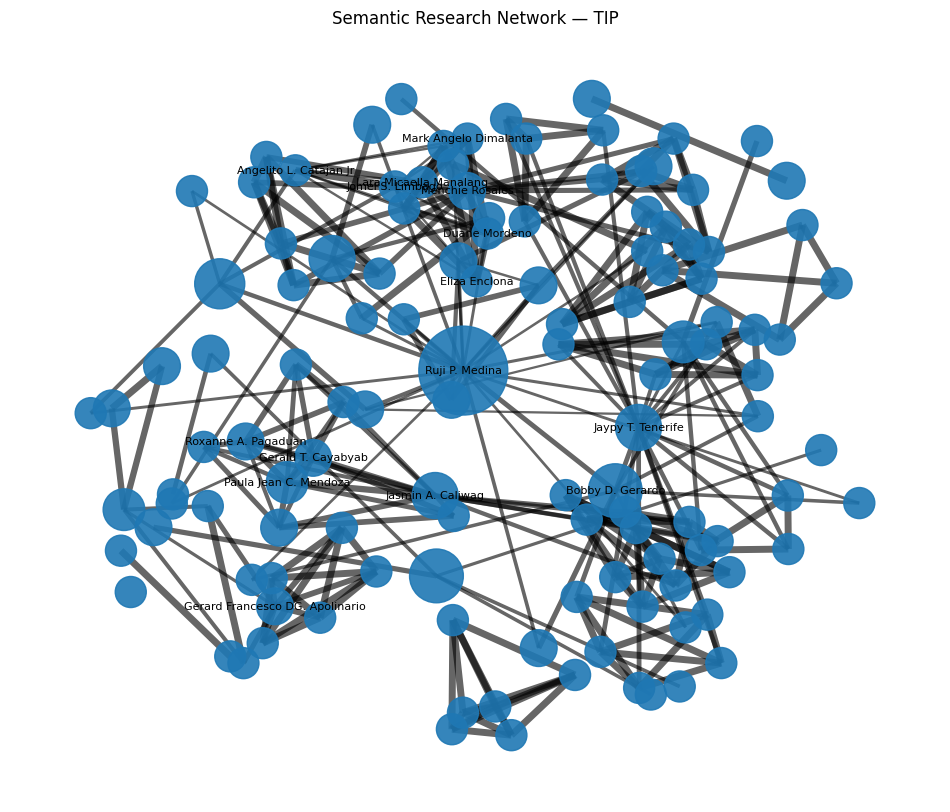

In [ ]:
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)

top_deg = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:15]
top_labels = {n: n for n, _ in top_deg}
nx.draw_networkx_labels(G, pos, labels=top_labels, font_size=8)
plt.title("Semantic Research Network — TIP")
plt.axis('off')
plt.show()

In [ ]:
pip install pyvis

In [ ]:
from pyvis.network import Network
import json

# Create interactive network
net = Network(height="800px", width="100%", bgcolor="#ffffff", font_color="black", notebook=True)

# Create a clean copy of the graph with native Python types
G_clean = nx.Graph()

# Add nodes with native Python types
for node, data in G.nodes(data=True):
    clean_data = {}
    for key, value in data.items():
        # Convert numpy types to native Python types
        if hasattr(value, 'item'):  # For numpy types
            clean_data[key] = value.item()
        else:
            clean_data[key] = value
    G_clean.add_node(node, **clean_data)

# Add edges with native Python types
for u, v, data in G.edges(data=True):
    clean_data = {}
    for key, value in data.items():
        # Convert numpy types to native Python types
        if hasattr(value, 'item'):  # For numpy types
            clean_data[key] = value.item()
        else:
            clean_data[key] = value
    G_clean.add_edge(u, v, **clean_data)

# Convert your cleaned NetworkX graph to PyVis
net.from_nx(G_clean)

# Customize node physics for better spacing
net.toggle_physics(True)
net.force_atlas_2based()

# Optional: adjust node size and edge thickness with native Python types
for node in net.nodes:
    node_id = node['id']
    degree = G.degree(node_id)
    # Ensure we're using native Python int
    if hasattr(degree, 'item'):
        degree = degree.item()
    node['size'] = 10 + degree * 2

for edge in net.edges:
    edge['width'] = edge.get('value', 2)

# Save and show with CDN resources set to 'remote' to avoid display issues
net.show("semantic_network_TIP.html")

semantic_network_TIP.html


###**Existing vs Potential Collaborations**

In [ ]:
# Build a true coauthorship graph (actual collaborations)
G_coauthor = nx.Graph()
for _, row in df.iterrows():
    authors = row['author_list']
    for i in range(len(authors)):
        for j in range(i+1, len(authors)):
            G_coauthor.add_edge(authors[i], authors[j])

print(f"Co-authorship graph: {G_coauthor.number_of_nodes()} nodes, {G_coauthor.number_of_edges()} edges")

# Show ALL semantic similarity edges (existing + potential)
print("\n=== ALL SEMANTIC SIMILARITY EDGES ===")
edges_data = []
for u, v, data in G.edges(data=True):
    edges_data.append({
        'Author_A': u,
        'Author_B': v,
        'Similarity_Score': round(data['weight'], 3),
        'Already_Collaborators': 'Yes' if G_coauthor.has_edge(u, v) else 'No'
    })

all_edges_df = pd.DataFrame(edges_data).sort_values('Similarity_Score', ascending=False)
print("Top 20 most similar author pairs:")
display(all_edges_df.head(20))

Co-authorship graph: 122 nodes, 270 edges

=== ALL SEMANTIC SIMILARITY EDGES ===
Top 20 most similar author pairs:


,Author_A,Author_B,Similarity_Score,Already_Collaborators
284,Al–Monte Vince M. Calo,Fredilyn B. Calanda,1.0,Yes
283,Noelyn M. De Jesus,Dylan Josh Domingo Lopez,1.0,Yes
282,Mhayvrick D. Macasieb,Veronica Jones M. Magno,1.0,Yes
281,Julianne Grace C. Gomez,Veronica Jones M. Magno,1.0,Yes
261,Lorna C. Lim,Melrose Q. Lumbao,1.0,Yes
280,Julianne Grace C. Gomez,Mhayvrick D. Macasieb,1.0,Yes
279,Justine Troy C. Espiritu,Veronica Jones M. Magno,1.0,Yes
262,Lorna C. Lim,Karren V. De Lara,1.0,Yes
259,Lorna C. Lim,Janice A. Capule,1.0,Yes
260,Lorna C. Lim,Karen Joyce S. Ison,1.0,Yes


In this case, the table shows a perfect `Similarity_Score` of **1.0**. This is because the people are actually **co-authors** of a paper.

In the following code, potential collaborations will be identified to nodes who are not actual co-authors.

These are identified through high semantic similarity (≥0.15) between authors who have not co-authored any papers. Such connections suggest shared research interests and thematic alignment, indicating opportunities for future collaborative efforts.

In [ ]:
# Build a true coauthorship graph (actual collaborations)
G_coauthor = nx.Graph()
for _, row in df.iterrows():
    authors = row['author_list']
    for i in range(len(authors)):
        for j in range(i+1, len(authors)):
            G_coauthor.add_edge(authors[i], authors[j])

# Potential collaborations = semantic similarity edges that are not actual coauthors
potential_edges = []
for u, v, data in G.edges(data=True):
    if not G_coauthor.has_edge(u, v):  # not yet co-authored
        potential_edges.append({
            'Author_A': u,
            'Author_B': v,
            'Similarity_Score': round(data['weight'], 3)
        })

potential_df = pd.DataFrame(potential_edges).sort_values('Similarity_Score', ascending=False)
potential_df.head(20)

,Author_A,Author_B,Similarity_Score
0,Jonathan Taylar,John Joel Martinez,0.195
4,Angelito L. Catajan Jr,Mark Angelo Dimalanta,0.184
3,Angelito L. Catajan Jr,Duane Mordeno,0.184
5,Angelito L. Catajan Jr,Eliza Enclona,0.184
6,Angelito L. Catajan Jr,Lara Micaella Manalang,0.184
8,Angelito L. Catajan Jr,Laurence Lopez,0.184
7,Angelito L. Catajan Jr,Mary Joyce Magbanua,0.184
11,Jomel S. Limbago,Eliza Enclona,0.184
12,Jomel S. Limbago,Lara Micaella Manalang,0.184
9,Jomel S. Limbago,Duane Mordeno,0.184


##**Social Network Analysis**

###**Centrality Measures**

####Degree Centrality and Betweenness Centrality

In [ ]:
deg = dict(G.degree())
strength = dict(G.degree(weight='weight'))
betw = nx.betweenness_centrality(G, weight=None, normalized=True)

try:
    inv_weight = {}
    for u,v,d in G.edges(data=True):
        w = d.get('weight', 0.0001)
        inv_weight[(u,v)] = 1.0 / w if w>0 else 1e6

    for u,v,d in G.edges(data=True):
        G[u][v]['inv_w'] = inv_weight[(u,v)]
    betw_w = nx.betweenness_centrality(G, weight='inv_w', normalized=True)
except Exception as e:
    betw_w = betw  # fallback

####Closeness Centrality and Eigenvector Centrality

In [ ]:
closeness = nx.closeness_centrality(G)
try:
    eig = nx.eigenvector_centrality_numpy(G, weight='weight')
except Exception:
    eig = {n: 0.0 for n in G.nodes()}

In [ ]:
metrics = []
for n in G.nodes():
    metrics.append({
        'author': n,
        'n_papers': G.nodes[n].get('n_papers', 0),
        'degree': deg.get(n,0),
        'strength': strength.get(n,0.0),
        'betweenness': betw.get(n,0.0),
        'closeness': closeness.get(n,0.0),
        'eigenvector': eig.get(n,0.0)
    })

In [ ]:
metrics_df = pd.DataFrame(metrics).sort_values('degree', ascending=False).reset_index(drop=True)
metrics_df.head(20)

,author,n_papers,degree,strength,betweenness,closeness,eigenvector
0,Ruji P. Medina,19,23,7.686999,0.048435,0.175046,0.0
1,Jaypy T. Tenerife,4,18,9.259296,0.020187,0.149031,0.0
2,Jasmin A. Caliwag,4,13,7.858665,0.005781,0.106557,0.0
3,Menchie Rosales,2,10,7.176541,0.003387,0.081967,0.0
4,Gerard Francesco DG. Apolinario,2,8,5.636522,0.003387,0.068306,0.0
5,Paula Jean C. Mendoza,3,8,5.796735,0.000361,0.076958,0.0
6,Jomel S. Limbago,1,8,2.578278,0.009755,0.107905,0.0
7,Angelito L. Catajan Jr,1,8,2.578278,0.009755,0.107905,0.0
8,Gerald T. Cayabyab,2,7,4.935361,0.000192,0.072908,0.0
9,Roxanne A. Pagaduan,2,7,4.738893,0.000192,0.072908,0.0


1. The network is **highly dependent on Ruji P. Medina**. If they were to leave, the network could fragment. Encouraging Medina to collaborate with other central figures (like Tenerife) would increase robustness.

2. **Jaypy T. Tenerife** should be leveraged **to foster interdisciplinary projects**, as they naturally connect different parts of the network.

3. The consistently zero Eigenvector Centrality for all top authors is a critical finding. It **suggests the network may have a "hub-and-spoke" structure around a few stars** (especially Medina) **rather than a "core-periphery" structure** with a tightly interconnected elite. This can sometimes indicate a less resilient network.

4. Authors like Caliwag, Rosales, and Mendoza represent strong, productive research clusters. Efforts should be made to connect these clusters to the main hub and to each other to enhance cross-pollination of ideas.

###**Dyadic & Path Analysis**

This application will explore relationships between authors to identify bridge researchers connecting multiple topic areas.

In [ ]:
def top_neighbors(author, top_k=10):
    if author not in G:
        return []
    neighs = list(G[author].items())
    neighs_sorted = sorted(neighs, key=lambda x: x[1].get('weight',1), reverse=True)
    return [(n, d.get('weight', 1.0)) for n,d in neighs_sorted[:top_k]]

In [ ]:
# Checking for the highest-pub author
example_author = authors_df['author'].iloc[0]
print("Top neighbors for:", example_author)
print(top_neighbors(example_author, top_k=10))

Top neighbors for: Ruji P. Medina
[('Bobby D. Gerardo', 0.6327999850362213), ('Arnel C. Fajardo', 0.5453476459497019), ('Ariel M. Sison', 0.5289419673583836), ('Ceferino V. Llamelo', 0.4743625366136442), ('Ailen B. Garcia', 0.40893553749204076), ('Ma. Esther B. Chio', 0.40085803939560594), ('Jonathan Taylar', 0.3759536291150898), ('Jason S. Artates', 0.3477749018547664), ('Daryl John C. Ragadio', 0.3465429651822706), ('John Joel Martinez', 0.33715008799017177)]


####Shortest path between two authors

In [ ]:
def shortest_path(author_a, author_b, weight_attr='inv_w'):
    if author_a not in G or author_b not in G:
        return None
    try:
        path = nx.shortest_path(G, source=author_a, target=author_b, weight=weight_attr)
        length = nx.shortest_path_length(G, source=author_a, target=author_b, weight=weight_attr)
        return path, length
    except nx.NetworkXNoPath:
        return None

####Find bridging nodes: nodes with high betweenness but moderate degree

In [ ]:
bridges = metrics_df[(metrics_df['betweenness'] > metrics_df['betweenness'].quantile(0.75)) &
                     (metrics_df['degree'] < metrics_df['degree'].quantile(0.75))]
bridges.head(10)

,author,n_papers,degree,strength,betweenness,closeness,eigenvector
78,Mary Joy D. Viñas,1,4,1.898398,0.000045,0.109403,0.0
79,Mark Jovic A. Daday,1,4,1.898398,0.000045,0.109403,0.0
80,Jason S. Artates,2,4,2.256639,0.000045,0.109403,0.0
81,Jonathan Taylar,2,4,1.765130,0.000045,0.109403,0.0
82,Ceferino V. Llamelo,2,4,1.538449,0.001219,0.123079,0.0
102,Great Allan M. Ong,2,2,0.989294,0.000677,0.029508,0.0


The  data confirms the existence of a **tightly-knit team** consisting of **Mary Joy D. Viñas, Mark Jovic A. Daday, Jason S. Artates, and Jonathan Taylar**. This is conclusively demonstrated by their identical degree (4), identical closeness centrality (0.1094), and now, critically, their identical betweenness centrality (0.000045).
* This new parity in betweenness indicates that within this cluster, no single member acts as a dominant internal bridge; they are all directly and equally connected to one another in a cohesive "clique."
* This suggests a flat, highly collaborative team structure, likely working closely on the same set of projects, as evidenced by their similar tie strengths.

Within this context, *Ceferino V. Llamelo's role becomes even more pronounced*. While he shares the same degree (4) as the core cluster, his metrics are distinctly different.
* **His significantly higher betweenness centrality (0.001219) solidifies his position as the crucial local broker**, making him **the primary connector linking this dense cluster to other parts of the network**.
* His **higher closeness centrality (0.1231)** further supports this, indicating he is, on average, **closer to all other nodes in the network** than his colleagues are. He is the gateway through which the cluster accesses and influences the wider research community.

The universal eigenvector centrality of 0.0 remains, reinforcing the overarching network characteristic: Influence is not concentrated among a group of mutually connected hubs but is channeled through specific brokers like Llamelo and Ong.

###**Community Detection**

This social network analysis will apply methods such as Louvain, Infomap, and Label Propagation to detect thematic research communities and overlapping fields.

In [ ]:
!pip install python-louvain
import community.community_louvain as community_louvain

####Louvain

In [ ]:
partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'louvain_community')

####Label Propagation

In [ ]:
lp_communities = nx.algorithms.community.label_propagation_communities(G)
lp_map = {}
for i, comm in enumerate(lp_communities):
    for n in comm:
        lp_map[n] = i
nx.set_node_attributes(G, lp_map, 'labelprop_community')

In [ ]:
# Summarize community sizes (Louvain)
from collections import Counter
comm_counts = Counter(partition.values())
print("Louvain communities:", len(comm_counts))
print("Sizes:", comm_counts.most_common()[:10])

Louvain communities: 15
Sizes: [(0, 24), (2, 16), (3, 14), (4, 11), (7, 11), (8, 8), (1, 7), (9, 6), (10, 6), (11, 6)]


In [ ]:
# Create DataFrame of author, community labels, centrality metrics
comm_df = metrics_df.merge(authors_df[['author']], left_on='author', right_on='author', how='right')
comm_df['louvain_comm'] = comm_df['author'].map(partition)
comm_df['labelprop_comm'] = comm_df['author'].map(lp_map)

comm_df

,author,n_papers,degree,strength,betweenness,closeness,eigenvector,louvain_comm,labelprop_comm
0,Ruji P. Medina,19,23,7.686999,0.048435,0.175046,0.0,0,0
1,Bobby D. Gerardo,6,7,3.314492,0.000948,0.114160,0.0,0,0
2,Melvin A. Ballera,6,5,2.216848,0.001897,0.042155,0.0,1,1
3,Arnel C. Fajardo,5,6,3.044041,0.025132,0.140662,0.0,0,0
4,Ariel M. Sison,4,5,2.740714,0.000339,0.110944,0.0,0,0
...,...,...,...,...,...,...,...,...,...
118,Dylan Josh Domingo Lopez,1,3,2.132591,0.000000,0.048216,0.0,4,4
119,Rodel D. Bacuna,1,1,0.392034,0.000000,0.024590,0.0,1,1
120,Roman M. Richard,1,1,0.702010,0.000000,0.061862,0.0,2,2
121,Al–Monte Vince M. Calo,1,2,1.209699,0.000000,0.106447,0.0,0,0


####**Louvain Community**

In [ ]:
print(f"Number of Louvain communities detected: {len(comm_counts)}")

Number of Louvain communities detected: 15


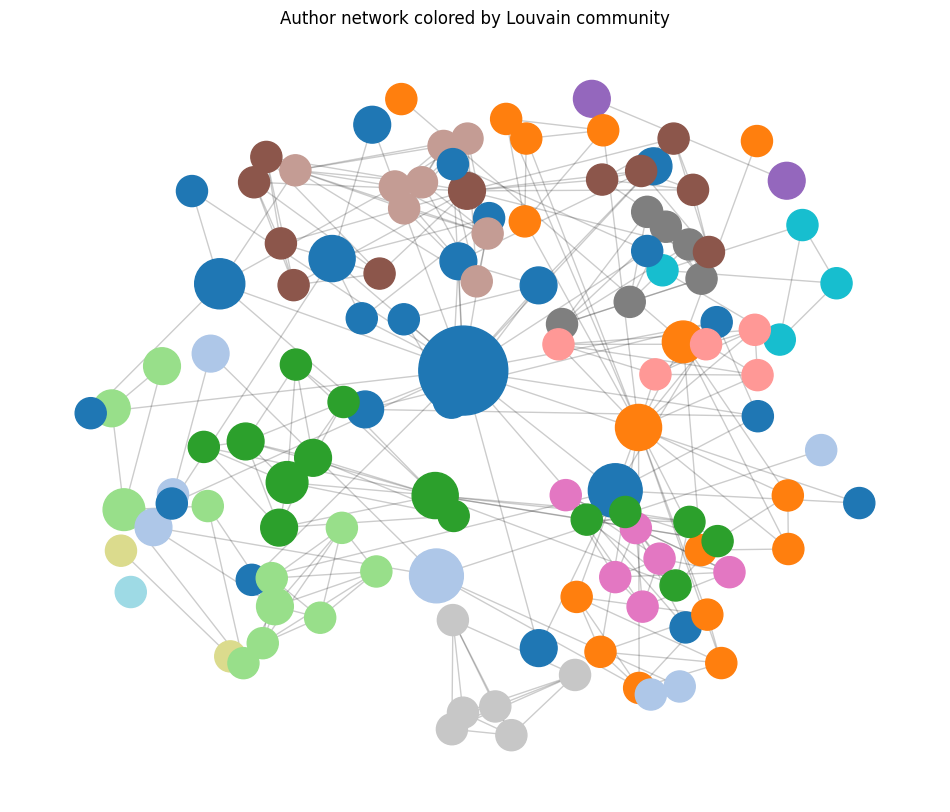

In [ ]:
communities = list(set(partition.values()))
color_map = {c:i for i,c in enumerate(communities)}
node_colors = [color_map[partition[n]] for n in G.nodes()]

plt.figure(figsize=(12,10))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.tab20, node_color=node_colors)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Author network colored by Louvain community")
plt.axis('off')
plt.show()

In [ ]:
from collections import defaultdict

# Group authors by community
community_groups = defaultdict(list)
for author, comm_id in partition.items():
    community_groups[comm_id].append(author)

# Display the communities and their members
for comm_id, authors in community_groups.items():
    print(f"Community {comm_id} ({len(authors)} authors):")
    print(", ".join(authors))
    print("-" * 80)

Community 0 (24 authors):
Ruji P. Medina, Bobby D. Gerardo, Arnel C. Fajardo, Ariel M. Sison, Ma. Esther B. Chio, Jonathan Taylar, Jason S. Artates, Ailen B. Garcia, Ceferino V. Llamelo, John Joel Martinez, Daryl John C. Ragadio, Guilbert Nicanor A. Atillo, Archie O. Pachica, Jovelin M. Lapates, Vivian O. Ecunar, Dina P. Hassan, Jolitte A. Villaruz, James Cloyd M. Bustillo, Jocelyn L. Garrido, Markdy Y. Orong, Mark Jovic A. Daday, Mary Joy D. Viñas, Al–Monte Vince M. Calo, Fredilyn B. Calanda
--------------------------------------------------------------------------------
Community 1 (7 authors):
Melvin A. Ballera, Mervin Jommel T. De Jesus, Great Allan M. Ong, Lea Erica M. Alcao, Jennifer Anne A. Repaso, Mark Reden S. Pacaon, Rodel D. Bacuna
--------------------------------------------------------------------------------
Community 2 (16 authors):
Jaypy T. Tenerife, Alonica R. Villanueva, Lance Kenneth S. Narvaez, Ma. Elena C. Estebal, Menchie M. Rosales, Rafael R. Veloso, Ralfh Rowie 

####**Label Propagation Community**

In [ ]:
# Calculate the number of Label Propagation communities
lp_comm_counts = len(set(lp_map.values()))
print(f"Number of Label Propagation communities detected: {lp_comm_counts}")

Number of Label Propagation communities detected: 16


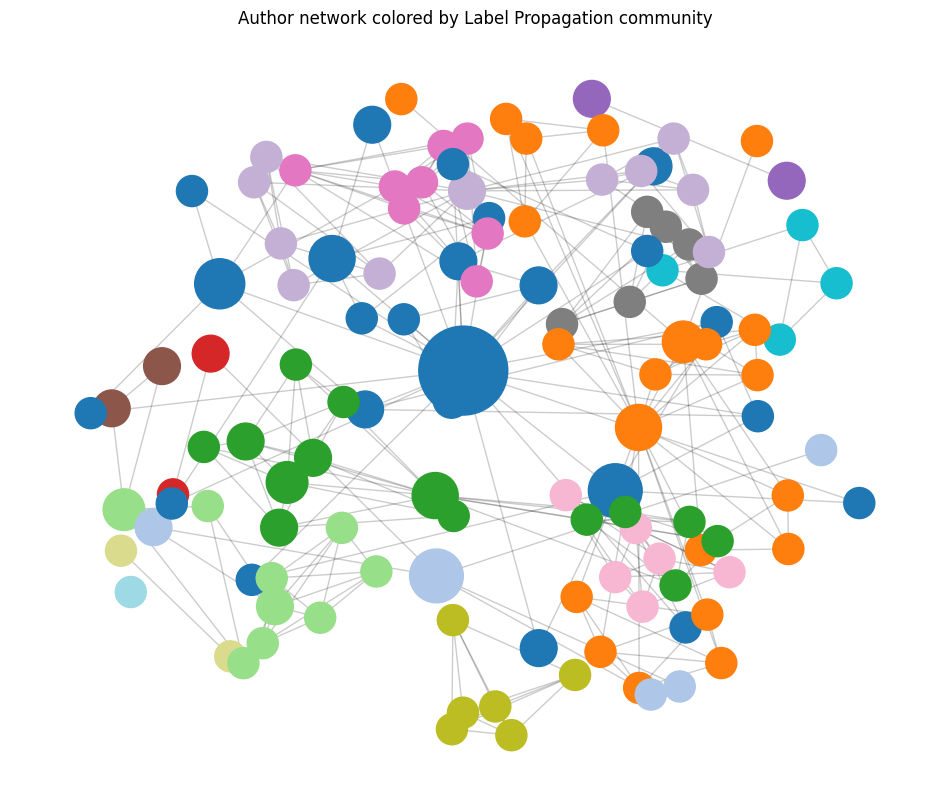

In [ ]:
communities_lp = list(set(lp_map.values()))
color_map_lp = {c:i for i,c in enumerate(communities_lp)}
node_colors_lp = [color_map_lp[lp_map[n]] for n in G.nodes()]

plt.figure(figsize=(12,10))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.tab20, node_color=node_colors_lp)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Author network colored by Label Propagation community")
plt.axis('off')
plt.show()

In [ ]:
from collections import defaultdict

# Group authors by Label Propagation community
lp_community_groups = defaultdict(list)
for author, comm_id in lp_map.items():
    lp_community_groups[comm_id].append(author)

# Display the communities and their members
for comm_id, authors in sorted(lp_community_groups.items()):
    print(f"Label Propagation Community {comm_id} ({len(authors)} authors):")
    print(", ".join(authors))
    print("-" * 80)

Label Propagation Community 0 (24 authors):
James Cloyd M. Bustillo, Jolitte A. Villaruz, Archie O. Pachica, Guilbert Nicanor A. Atillo, Ailen B. Garcia, Dina P. Hassan, Jonathan Taylar, Ceferino V. Llamelo, Ariel M. Sison, Vivian O. Ecunar, Jocelyn L. Garrido, Daryl John C. Ragadio, Bobby D. Gerardo, Jason S. Artates, Ruji P. Medina, Mark Jovic A. Daday, Ma. Esther B. Chio, Jovelin M. Lapates, Al–Monte Vince M. Calo, Markdy Y. Orong, Arnel C. Fajardo, Mary Joy D. Viñas, Fredilyn B. Calanda, John Joel Martinez
--------------------------------------------------------------------------------
Label Propagation Community 1 (5 authors):
Rodel D. Bacuna, Mervin Jommel T. De Jesus, Melvin A. Ballera, Jennifer Anne A. Repaso, Mark Reden S. Pacaon
--------------------------------------------------------------------------------
Label Propagation Community 2 (21 authors):
Jaypy T. Tenerife, Jeroncil L. Sanchez, Rafael R. Veloso, Justine Julia Marie R. Sevilla, Hannah Mae R. Bertulfo, Jayson Zamir

####Top Terms per Community

In [ ]:
from collections import defaultdict
import numpy as np

terms = np.array(tfidf.get_feature_names_out())
comm_texts = defaultdict(list)
for node in G.nodes():
    comm = partition[node]
    comm_texts[comm].append(authors_df[authors_df['author']==node]['abstract_concat'].iloc[0])

for c, texts in comm_texts.items():
    corpus = [" ".join(texts)]
    vec = tfidf.transform(corpus)
    topn = vec.toarray().flatten().argsort()[-10:][::-1]
    print("Community", c, "top terms:", ", ".join(terms[topn]))

Community 0 top terms: model, accuracy, enhanced, speech, lstm, air, pca, aes 256, aes, 256
Community 1 top terms: stemming, ahp, algorithm, recommendation, svm, decision, machine, making, algorithms, template
Community 2 top terms: learning, astronomy, digital, flashlight, msmes, education, insights, key, adoption, ar
Community 3 top terms: fuel, road, mathematical, application, web, infrastructure, signatures, road infrastructure, algorithm, price
Community 4 top terms: load, forecasting, load forecasting, blockchain, demand, linear, term, load demand, luzon, models
Community 6 top terms: optimization, holt, holt winters, hosting, hosting capacity, winters, forecasting, ga, capacity, network based
Community 7 top terms: water, mangoes, poultry, farms, device, export, toxicity, mango, broiler, industry
Community 8 top terms: water quality, water, quality, parameters, gathered, quality control, camera, control, heater, fish
Community 9 top terms: drying, temperature, moisture, desired,